lien pas mal sur eigenmaps: https://www.youtube.com/watch?v=BgMFBqrtCwo

**Plusieurs pistes pour le projet déjà explorées mais pas convaincantes à l'heure actuelle (entre autres à cause des trucs qui s'avèrent être faux) :**

**1 - kmeans peut prendre pas mal de paramètres, dont un set de centres initiaux pour le clustering. ça fait effet pour avoir testé. Par contre, il faudrait trouver des infos qui relient à des aéroports bien choisis (genre le plus gros de chaque continent) et mettre ça en init. Plus bas il y a node_tuned, ce sont les noeuds initiaux (la plupart les gros hubs, sinon des noeuds bien choisis).**

**2 - en supprimant la ligne edges.drop_duplicates() on peut modifier les poids aussi en fonction du trafic entre deux aéroports (en faisant weighted_matrix_inv[i, j] += np.exp(-dist/sigma)), ça peut rapprocher artificiellement deux aéroports ultraconnectés mais je ne sais pas si c'est ouf vu que ça devrait rapprocher des gros aéroports éloignés**

**3 - Il existe un truc qui s'appelle community qui a l'air stylé par rapport au rendu de kmeans (http://cjauvin.blogspot.com/2014/03/k-means-vs-louvain.html) mais j'ai pas réussi à l'installer correctement. Ce site (https://bitbucket.org/taynaud/python-louvain/issues/23/module-has-no-attribute-best_partition) peut aider à installer en installant python-louvain a la mano mais je suis une quiche pour faire ça haha**

# [Team 3] Project : Where are the continents according to the airport routes?
[team 3]: https://github.com/AmauV/NTDS

## Students

* Team: 3
* Students: Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado, Guilhem Noiraud, Amaury Véron
* Dataset: Flight routes

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
from scipy import sparse
import scipy.sparse.linalg
import networkx as nx
from sklearn.cluster import KMeans
import folium

# Creation of the weighted matrix

### Dataset of routes

In [3]:
features = pd.read_csv("routes.dat", names = ["airline",
                                              "airline_id",
                                              "source_airport",
                                              "source_airport_id",
                                              "destination_airport",
                                              "destination_airport_id",
                                              "codeshare",
                                              "stops",
                                              "equipment"])
features.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


### Get nodes and edges

In [4]:
source_airports = features[["source_airport_id", "source_airport"]]
source_airports.columns = ["airport_id", "airport"]

destination_airports =  features[["destination_airport_id", "destination_airport"]]
destination_airports.columns = ["airport_id", "airport"]

nodes = pd.concat([source_airports,destination_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace='\\N', value=np.NaN, inplace=True)
nodes.dropna(axis=0, inplace=True)
nodes["airport_id"] = nodes["airport_id"].apply(int)   #Convert IDs to int to allow merge

edges = features[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace='\\N', value=np.NaN)
edges = edges.dropna(axis=0)
edges["source_airport_id"] = edges["source_airport_id"].apply(int)   #Convert IDs to int to allow merge
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)   #Convert IDs to int to allow merge

nodes.head()

,airport_id,airport
0,2965,AER
1,2966,ASF
3,2968,CEK
5,4029,DME
9,6156,EGO


In [5]:
edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


### Dataset of information about airports

In [6]:
airports = pd.read_csv("airports.dat", names = ["airport_id", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"])

In [7]:
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


### Add Latitudes and Longitudes to nodes DataFrame

In [8]:
nodes = nodes.merge(airports[["airport_id", "Latitude", "Longitude", "TzDatabase"]], how='left', on='airport_id')
nodes["TzDatabase"] = nodes["TzDatabase"].apply(lambda x: str(x).split("/")[0])
nodes.columns = ["airport_id", "airport", "Latitude", "Longitude", "Continent"]
nodes.set_index("airport_id", inplace=True)

In [9]:
nodes.head()

,airport,Latitude,Longitude,Continent
airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


In [10]:
nodes.dropna(inplace=True)

### Convert airports IDs to node index

In [11]:
# Conversion table from airport_id to node index.
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx.reset_index(level = 0, inplace = True)
airport_id2idx.columns = ["node_idx", "airport_id"]
airport_id2idx.set_index("airport_id", inplace = True)
airport_id2idx.head()

,node_idx
airport_id,
2965,0
2966,1
2968,2
4029,3
6156,4


In [12]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "source_airport_id",
                 right_index = True,
                 sort = False)

In [13]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "destination_airport_id",
                 right_index = True,
                 sort = False,
                 suffixes = ("_source", "_destination"))

edges = edges.drop_duplicates()  # Avoid multilinks

In [14]:
edges.head()

,source_airport_id,destination_airport_id,node_idx_source,node_idx_destination
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


In [15]:
n_nodes = nodes.shape[0]

### Create weighted matrix

***The weights are computed according to a heat kernel.***

In [16]:
sigma = 1200 #1751 is the mean distance, sigma is tunable and changes the results. Optimal : 1200
weighted_matrix_inv = np.zeros((n_nodes, n_nodes))

dists = []

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    if i != j:
        source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
        dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])
        dist = distance.geodesic(source_coords, dest_coords).km
        dists.append(dist)
        weighted_matrix_inv[i, j] = np.exp(-dist/sigma)
        
mean_dist = sum(dists)/len(dists)

# Make it symmetric
for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix_inv[i][j] != 0:
            weighted_matrix_inv[j][i] = weighted_matrix_inv[i][j]

In [17]:
print("Average distance:",int(np.round_(mean_dist,0)),"km.")

Average distance: 1751 km.


### Adjustment of the matrix to the biggest cluster

***The current matrix is made of several clusters due to the deletion of nodes of unkown location and unkown edges.***

In [18]:
df_biggest_cluster = pd.read_csv("df_biggest_cluster.csv")
df_biggest_cluster.set_index("airport_id", inplace=True)

In [19]:
airport_in_bg = np.array(df_biggest_cluster.columns)

#Check if Latitude and Longitude are known. Not considered if not
airport_in_bg = np.array([int(airport_in_bg[i]) for i in range(len(airport_in_bg)) if int(airport_in_bg[i]) in airport_id2idx.index])

In [20]:
#Breadth first search algorithm

def bfs(adjacency, start_node):
    """
    The BFS compute the shortest path for the hop-distance
        
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    start_node: int
        Node from where all distances are computed.
    
    Returns
    -------
    list of numpy arrays
        A list of distances from start_node.
    
    """
    distance_from_start_node = np.Inf * np.ones(adjacency.shape[0])   # Unlabelled are set to inf
    distance_from_start_node[start_node] = 0
    queue = [(start_node, 0)]
    
    while queue:
        current_node = queue.pop(0)
        link_nodes = link_nodes_unlabelled(adjacency, current_node, distance_from_start_node)
        for node in link_nodes:
            distance_from_start_node[node[0]] = node[1]
        queue += link_nodes
    
    return distance_from_start_node


def link_nodes_unlabelled(adjacency, current_node, distance_from_start_node):
    """
    Function that returns new nodes linked to current_node and their hop-distance to origin.
        
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    current_node: int
        Node where we look at the connections.
    distance_from_start_node: numpy array
        Array of distances.
    
    Returns
    -------
    list of numpy arrays
        A list of new nodes linked to current_node.
    
    """
    link_nodes = []
    for idx in range(adjacency.shape[0]):
        if adjacency[current_node[0],idx] > 0 and distance_from_start_node[idx] == np.Inf:
            link_nodes.append((idx, current_node[1]+1))     # Add unlabelled nodes linked to the current node with label +1
    return link_nodes

In [21]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    components = []
    n_nodes = adjacency.shape[0]
    n = 1
    unseen_nodes = [i for i in range(n_nodes)]
    a=[]
    while unseen_nodes:
        connected_components = []
        current_node = np.random.choice(unseen_nodes)   # Choose a random unseen node
        distance_from_start_node = bfs(adjacency, current_node)  # Compute BFS from this node
        
        for idx, dist in enumerate(distance_from_start_node):
            if dist != np.Inf:     # The connected nodes (from a source) are the labelled nodes !
                connected_components.append(idx)
        
        unseen_nodes = [e for e in unseen_nodes if e not in connected_components] # Update unseen nodes
        a.append(connected_components)
    return a

In [22]:
bg_indices = find_components(weighted_matrix_inv)[0]

In [23]:
bg_heat = weighted_matrix_inv[:,bg_indices][bg_indices,:]
n_nodes_bg = len(bg_heat)
n_nodes_bg

3154

### Verification of some properties

In [24]:
#Check the connected components of bg_heat
len(sorted(nx.connected_component_subgraphs(nx.from_numpy_matrix(bg_heat)), key = len, reverse=True))

1

In [25]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [26]:
#Check the symmetry
check_symmetric(bg_heat)

True

### Plot of the inverse distance repartition

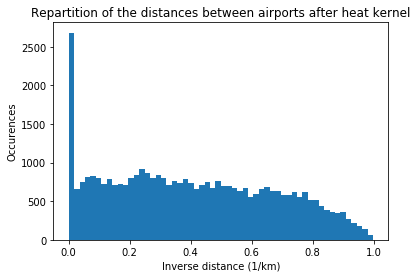

In [27]:
values = []

for i in range(n_nodes_bg):
    for j in range(n_nodes_bg):
        if bg_heat[i][j] != 0:
            values.append(bg_heat[i][j])
            
plt.hist(values, bins = int(np.sqrt(n_nodes_bg)))
plt.xlabel("Inverse distance (1/km)")
plt.ylabel("Occurences")
plt.title("Repartition of the distances between airports after heat kernel")
plt.show()

# Labeling of the airports

### Creation of the ground truth

In [28]:
#ground truth
dic = {"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10,np.nan:10}

labels = nodes.Continent
labels = np.array(labels.replace(dic).tolist())

In [29]:
#https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
dic_color = {0: '#e6194b',
             1: '#3cb44b',
             2: '#ffe119',
             3: '#4363d8',
             4: '#f58231',
             5: '#911eb4',
             6: '#46f0f0',
             7: '#f032e6',
             8: '#bcf60c',
             9: '#fabebe',
             10: '#008080',
             11: '#e6beff',
             12: '#9a6324',
             13: '#000000',
             14: '#800000',
             15: '#aaffc3',
             16: '#808000',
             17: '#ffd8b1',
             18: '#000075',
             19: '#808080'
}

In [30]:
#Labels for bg_heat

labels_bg = labels[bg_indices]
     
ground_truth = [dic_color[labels_bg[i]-1] for i in range(len(labels_bg))]

In [31]:
#nan are changed to the color of the nearest neighbour

gt_without_nan = ground_truth.copy()
labels_without_nan = labels_bg.copy()
for i in range(len(ground_truth)):
    if gt_without_nan[i] == '#008080': #nan color
        weight = 0
        index_min = 0
        for j in range(len(ground_truth)-1):
            if (gt_without_nan[j]!='#008080') and bg_heat[i][j]>weight:
                weight = bg_heat[i][j]
                index_min = j
        gt_without_nan[i] = gt_without_nan[index_min]
        labels_without_nan[i] = labels_without_nan[index_min]

#Small correction, Pevek (Asia) in Russia is only connected to Moscow (Europe)
gt_without_nan[2774] = '#ffe119'
labels_without_nan[2274] = 2

### Creation of the laplacian eigenvectors

In [32]:
#Laplacian norm for bg_heat

laplacian_norm_bg, D = sparse.csgraph.laplacian(bg_heat, normed=True, return_diag=True)
D = np.diag(D)

computation_norm_bg =  scipy.linalg.eigh(laplacian_norm_bg)  #Compute orthonormale basis
eigenvectors_norm_bg = computation_norm_bg[1]
eigenvalues_norm_bg =  computation_norm_bg[0]

#Sort to have ordered eigenvalues
idx_norm_bg = eigenvalues_norm_bg.argsort()  
eigenvalues_norm_bg = np.round_(np.real(eigenvalues_norm_bg[idx_norm_bg]), 13)
eigenvectors_norm_bg = np.real(eigenvectors_norm_bg[:,idx_norm_bg])

#L*u = lambda*D*u
eigenvectors_u_bg = np.linalg.inv(D)@eigenvectors_norm_bg
eigenvalues_u_bg = eigenvalues_norm_bg

### Establishment of initial nodes for the clustering

***Initial nodes help to improve the clustering. The initial nodes are the main airport nodes for each continent, except for two continents.***

In [33]:
#Find the max degree node of each label

max_degree = np.zeros(10, dtype = int)
node_rank = np.zeros(10, dtype = int)

for i in range(n_nodes_bg):
    degree = sum(bg_heat[i]>0)
    if degree > max_degree[labels_bg[i]-1]:
        max_degree[labels_bg[i]-1] = degree
        node_rank[labels_bg[i]-1] = i

In [34]:
node_rank

array([ 186,  291,  211,  216, 1152,  296,   54, 1476, 1991,  244])

In [35]:
Y = eigenvectors_u_bg[:, 1:3] #Could be more than 2 eigenvectors

In [36]:
#Some initial nodes are chosen for better results

node_tuned = node_rank.copy()
node_tuned[5] = 2299 #Cooma, Australia
node_tuned[6] = 2292 #Espargos, Cap Verde

In [37]:
Y_init = np.array([Y[node_tuned[i]].tolist() for i in range(8)])

### Establishment of the airport clustering

***Eight clusters are made since we ignore the cluster of Arctic (1 airport) and unlabelled nodes, what represents 0.7% of the total.***

In [38]:
kmeans = KMeans(n_clusters=8, init=Y_init, n_init=1) 
kmeans.fit(Y);

In [39]:
lab = kmeans.labels_

In [40]:
lab_color = [dic_color[lab[i]] for i in range(len(lab))]

In [41]:
#label to plot one point on the map
#Useless, faudra le retirer

lab_empty = np.zeros(len(labels_bg))
lab_empty[2774] = 1 #number of the node you want to see
lab_test = [dic_color[lab_empty[i]] for i in range(len(lab_empty))]

### Plot on the first two eigenvectors

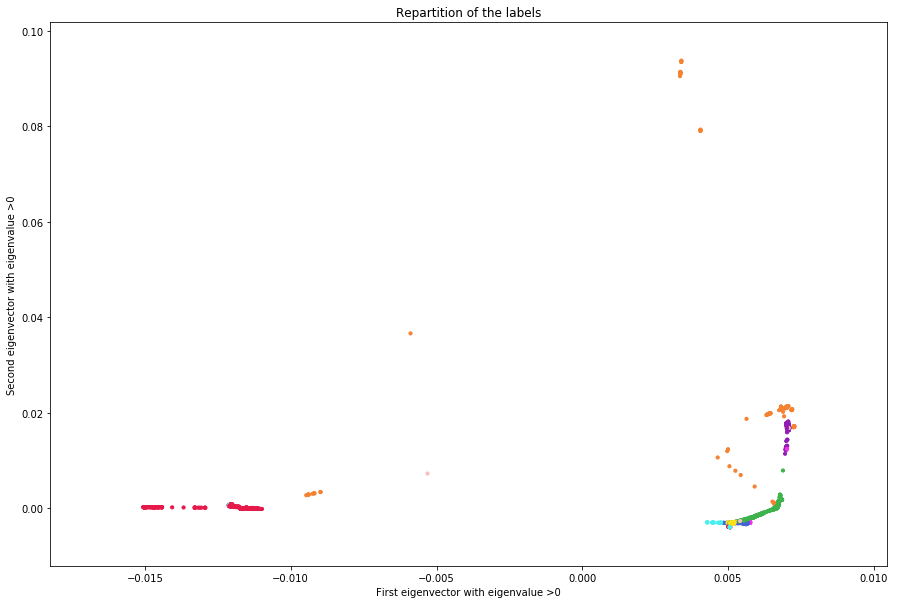

In [42]:
plt.figure(figsize=(15,10))
plt.scatter(Y[:,0],Y[:,1], s=10, c=ground_truth, cmap='rainbow')
plt.xlabel("First eigenvector with eigenvalue >0")
plt.ylabel("Second eigenvector with eigenvalue >0")
plt.title("Repartition of the labels")
plt.show()

In [43]:
nodes_bg = nodes.iloc[bg_indices]   #get nodes in biggest_cluster

In [44]:
#Creation of the map (called mapit). You can visualize it by opening the file on Internet
mapit = folium.Map(tiles="Mapbox Bright")
j = 0
corr = 0

#plot nodes
for i in nodes_bg.iterrows():
    coord = [i[1].Latitude, i[1].Longitude]
    folium.CircleMarker( location=coord, radius=1, color=lab_color[j], fill=True).add_to(mapit)
    j += 1

# #plot edges. Comment everything below to go faster
# coords = np.zeros((max(nodes.index)+1,2))
# for i in nodes.iterrows():
#     coords[i[0]] = (i[1].Latitude, i[1].Longitude)

# #plot edges 
# for i in edges.iloc[:].iterrows():
#     my_edge = [coords[i[1].source_airport_id], coords[i[1].destination_airport_id]]
#     if i[1].source_airport_id==2931 or i[1].destination_airport_id==2931:
#         folium.vector_layers.PolyLine(my_edge, color="black", weight=0.5, opacity=0.5).add_to( mapit )              

In [45]:
mapit.save('mapit.html')

# Computing the error between ground truth and our prediction

The idea is to compute the percentage of good predictions we can get from our model compared to the ground truth labels i.e how many airports are correclty labelled in percentage.
Correctly labelled means that the cluster in which the airport is attributed is the true continent label of the airport.

The problem is that K-Means produce several clusters randomly : if we compute 10 clusters, we cannot easily associate each one to a continent to compare.
For example : if a cluster is formed on the basis of Europe and Africa, what continent should it be associated to ?

One possible idea is to choose keys of the continents that will represent their clusters. We can say that if we take Paris as the key to Europe, we compare the cluster in which Paris is, and the continent Europe. This method is not flawless, but can serve as a way to begin the experiments on finding a good loss function for our optimization. The aim is to automatize this process which is time-consuming and imprecise.

The continent labels we have are : 
"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10

Keys for the continents :

America = Minneapolis

Asia = Seoul

Europe = Geneva

Africa = Cape Town

Pacific = Papeete

Australia = Brisbane

Atlantic = Ponta Delgada

Indian = Mumbai

Arctic = Svalbard (the only one in Arctic)

\N = Agartha TMTC


### Find the keys for the continents

In [46]:
key_city = ["Minneapolis", "Seoul", "Geneva", "Cape Town", "Papeete", "Sydney", "Ponta Delgada", "Mumbai"]
name_continent = ["America", "Asia", "Europe", "Africa", "Pacific", "Australia", "Atlantic", "Indian"]
n_continent = len(key_city)
key_index = np.zeros(n_continent)

# Let us find the keys of the index cities

for i in range(len(airports.City)):
    for continent in range(n_continent):
        if (airports.City[i] == key_city[continent]):
            key_index[continent] = i

In [47]:
latitude_R = airports.Latitude[key_index]
longitude_R = airports.Longitude[key_index]

# Finding the corresponding indexes in the new eigenmaps

new_index = np.empty(n_continent)

for i in range(n_nodes_bg):
    for c, key_idx in enumerate(key_index):
        if ((round(nodes.Latitude.values[bg_indices[i]],2) == round(latitude_R[key_idx], 2)) and (round(nodes.Longitude.values[bg_indices[i]],2) == round(longitude_R[key_idx], 2))):
            new_index[c] = i
            
new_index = new_index.astype(int)

***Warning : if two cities belonging to different continents have the same label by the previous technique, the following results are false.***

In [48]:
index_check = [lab[new_index[i]] for i in range(len(new_index))]
warning =  not(all(elem in index_check  for elem in np.arange(8).tolist()))
 
if warning:
    print("WARNING:")
    print("Several continents have been put together, the following results may be false.")
else:
    print('No apparent issue with the ground truth labeling.')

No apparent issue with the ground truth labeling.


### Comparison between the ground truth and our prediction

In [49]:
labels = lab[new_index]
total_airports = np.zeros(n_continent)
score_airports = np.zeros(n_continent)

for i in range(n_nodes_bg):
    for continent, continent_idx in enumerate(new_index):
        if(nodes.Continent.values[bg_indices[i]] == name_continent[continent]):
            total_airports[continent]+=1
            if(lab[i] == labels[continent]):
                score_airports[continent]+=1

In [50]:
#Percentage of correct guesses

mean_score = (sum(score_airports)/sum(total_airports))*100
final_score = np.zeros(n_continent)

for i in range(n_continent):
    final_score[i] = round(score_airports[i]/total_airports[i]*100, 2)
    print("Score for", name_continent[i], ":",final_score[i],"%.")
    
print("Global score:",np.round_(mean_score,2),"%.")

Score for America : 98.43 %.
Score for Asia : 58.41 %.
Score for Europe : 96.26 %.
Score for Africa : 56.69 %.
Score for Pacific : 18.18 %.
Score for Australia : 99.11 %.
Score for Atlantic : 53.12 %.
Score for Indian : 20.69 %.
Global score: 79.45 %.


### Presentation of the results

In [51]:
#Sort continents by decreasing score
idx_sc = np.flip(final_score.argsort())

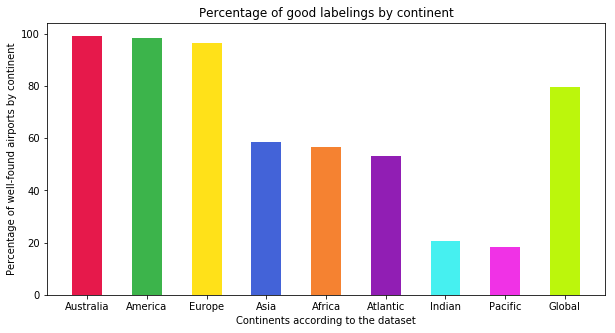

In [52]:
sorted_names = np.array(name_continent)[idx_sc].tolist()+['Global']
sorted_scores = final_score[idx_sc].tolist()+[mean_score]

plt.figure(figsize=(10,5))
plt.bar(sorted_names, sorted_scores, color=[dic_color[i] for i in range(len(key_city)+1)], width = 0.5)
plt.xlabel("Continents according to the dataset")
plt.ylabel("Percentage of well-found airports by continent")
plt.title("Percentage of good labelings by continent")
plt.show()

### Graph plot with networkx

In [53]:
# #Useful ???

# graph = nx.from_numpy_matrix(bg_heat)
# coords = nx.spring_layout(graph)

In [54]:
# #Useful ???

# plt.figure(figsize=(10,7))
# nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color = lab_color, cmap=plt.cm.jet)
# nx.draw_networkx_edges(graph, coords, alpha=0.3)
# plt.title("Labelled airports");

# Conclusion?

***Bla bla bla !***